In [2]:
!pip install seaborn==0.9.0
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import seaborn as sns
import matplotlib.collections as clt
import matplotlib.pyplot as plt
from google.colab import files 
import os
import math
import datetime
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="white")


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#establish location
PATH = "gdrive/My Drive/Kravitz Lab Google Drive/OSF_files/Matikainen_Ankney_Earnest_Ali_et_al_2021/data/Fig_4/"
print ("Number of files found: ") 
print(len(os.listdir (PATH))) 

Number of files found: 
10


In [7]:
# import all data from the CSV files in the PATH to a single dataframe, concatenating them vertically
df_multiday = pd.DataFrame()
files = os.listdir (PATH)
format = '%m/%d/%y %h:%m:%s'


for file in files:
  temp = pd.read_csv(PATH + file, parse_dates = True)
  
  temp['filename'] = os.path.basename(file) 

  temp.columns = temp.columns.str.strip()
    
  temp['MM:DD:YYYY hh:mm:ss'] =  pd.to_datetime(temp['MM:DD:YYYY hh:mm:ss'])
  temp ["RelativeTime"] = temp["MM:DD:YYYY hh:mm:ss"]  - temp["MM:DD:YYYY hh:mm:ss"] [0]
  temp ["poke_int"] = temp["RelativeTime"].diff()

  if temp['Retrieval_Time'].dtype == object: temp['Retrieval_Time']=np.NaN

  
  #Make difference variables
  temp["Errors"] = temp["Right_Poke_Count"].diff()  #create a new error column that shows the inactivt pokes
  
   
  #join each file together in one df 
  df_multiday = pd.concat ([df_multiday, temp]).reset_index(drop=True) 

In [8]:
df_multiday['Nighttime'] = ~np.logical_and((df_multiday["MM:DD:YYYY hh:mm:ss"].dt.hour>=6),(df_multiday["MM:DD:YYYY hh:mm:ss"].dt.hour<=18)) # Create a "Nighttime" variable for whether it is daytim


In [9]:
#convert delta date time to seconds
df_multiday['RelativeTime2'] = df_multiday['RelativeTime'] / np.timedelta64(1, 's')

#1 #filter retrieval time
df_multiday['Retrieval_Time'] = df_multiday['Retrieval_Time'].where(df_multiday['Retrieval_Time']<8000)
df_multiday['Retrieval_Time'] = df_multiday['Retrieval_Time'].where(df_multiday['Retrieval_Time']>0)

#change retrieval time to float
df_multiday['Retrieval_Time'] = df_multiday['Retrieval_Time'].astype(float)

#2 #filter for under 60 sec
df_multiday['Retrieval_Time_filt'] = df_multiday['Retrieval_Time'][df_multiday['Retrieval_Time']<=60]

#convert poke_int to seconds
df_multiday['poke_int'] = df_multiday['poke_int'].dt.seconds
df_multiday['poke_int'] = df_multiday['poke_int']/60


In [10]:
#bin data
#set bin width for use with .resample method
bin = "240min"

dfs = [rows for _, rows in df_multiday.groupby('filename')]

df_binned_multi = pd.DataFrame()
#iterate over all unique device IDs in df["Device_Number"]
for device in range (0, len(pd.unique (df_multiday["filename"]))):
  tempdf = pd.DataFrame()
  tempdf = dfs[device].resample(bin, on='RelativeTime').max()
  tempdf["Errors_binned"] = tempdf["Right_Poke_Count"].diff()  #create a new error column that shows the inactivt pokes
  tempdf["Successes_binned"] = tempdf["Left_Poke_Count"].diff()  #create a new error column that shows the activt pokes

  
  #concatenate data back together
  df_binned_multi = pd.concat ([df_binned_multi, tempdf])

hours = []
for i in df_binned_multi.index:
    hours.append(i.total_seconds()/3600)
df_binned_multi.index = hours
df_binned_multi['NewRT'] = df_binned_multi.index
df_binned_multi['active_bias'] = (df_binned_multi['Successes_binned'])/(df_binned_multi['Successes_binned']+df_binned_multi['Errors_binned'])*100

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

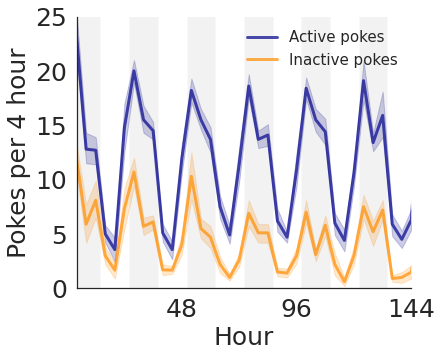

In [12]:
#Fig 4B

import matplotlib.ticker as ticker


sns_plot, ax = plt.subplots(figsize = (6,5))

sns.set_style("white")

sns_plot = sns.lineplot(data = df_binned_multi, 
                   y = "Successes_binned", 
                   x = "NewRT", label = 'Active pokes', 
                   color='darkblue',
                    lw=3, ci=67, alpha=.7)

sns_plot = sns.lineplot(data = df_binned_multi, 
                   y = "Errors_binned", 
                   x = "NewRT",  label = 'Inactive pokes',  
                   color='darkorange',
                    lw=3, ci=67, alpha=.7)

# Formating legend and labels

handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper right',prop={'size': 15}, frameon=False)

#plt.title("FR", fontsize=25)
plt.ylabel("Pokes per 4 hour", fontsize=25)
plt.xlabel("Hour", fontsize = 25)
plt.tick_params(axis='y', which='major', labelsize=25)
plt.tick_params(axis='x', which='major', labelsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.xaxis.set_major_locator(ticker.MultipleLocator(48))

#plt.ylim(-10,110)
plt.fill([0,14,14,0],[-1,-1,30,30],'grey', alpha=0.1)
plt.fill([26,38,38,26],[-1,-1,30,30],'grey', alpha=0.1)
plt.fill([50,62,62,50],[-1,-1,30,30],'grey', alpha=0.1)
plt.fill([74,86,86,74],[-1,-1,30,30],'grey', alpha=0.1)
plt.fill([98,110,110,98],[-1,-1,30,30],'grey', alpha=0.1)
plt.fill([122,134,134,122],[-1,-1,30,30],'grey', alpha=0.1)


plt.xlim(4,144) 
plt.ylim(0,25)

from google.colab import files
plt.savefig("6day.pdf", bbox_inches = 'tight')
files.download("6day.pdf")



In [13]:
#make a circadian graph 
df_circ = df_binned_multi.copy()
df_circ['hour'] = df_circ['MM:DD:YYYY hh:mm:ss'].dt.hour
df_circ.head(3)

,MM:DD:YYYY hh:mm:ss,Device_Number,Battery_Voltage,Motor_Turns,Session_Type,Event,Active_Poke,Left_Poke_Count,Right_Poke_Count,Pellet_Count,Retrieval_Time,filename,RelativeTime,poke_int,Errors,Nighttime,RelativeTime2,Retrieval_Time_filt,Errors_binned,Successes_binned,NewRT,active_bias,hour
0.0,2020-06-08 18:49:00,0.0,3.71,3.0,1.0,Poke,Left,20.0,8.0,20.0,NaN,FED1.CSV,0 days 03:54:00,142.0,1.0,0.0,14040.0,NaN,NaN,NaN,0.0,NaN,18.0
4.0,2020-06-08 22:36:00,0.0,3.69,3.0,1.0,Poke,Left,45.0,16.0,45.0,NaN,FED1.CSV,0 days 07:41:00,46.0,1.0,1.0,27660.0,NaN,8.0,25.0,4.0,75.757576,22.0
8.0,2020-06-09 02:14:00,0.0,3.67,3.0,1.0,Poke,Left,54.0,24.0,54.0,NaN,FED1.CSV,0 days 11:19:00,79.0,1.0,1.0,40740.0,NaN,8.0,9.0,8.0,52.941176,2.0


In [14]:
##make new classifer to plot correctly
groupsDict={}
groupsDict.update(dict.fromkeys([7], 1))
groupsDict.update(dict.fromkeys([8], 2))
groupsDict.update(dict.fromkeys([9], 3))
groupsDict.update(dict.fromkeys([10], 4))
groupsDict.update(dict.fromkeys([11], 5))
groupsDict.update(dict.fromkeys([12], 6))
groupsDict.update(dict.fromkeys([13], 7))
groupsDict.update(dict.fromkeys([14], 8))
groupsDict.update(dict.fromkeys([15], 9))
groupsDict.update(dict.fromkeys([16], 10))
groupsDict.update(dict.fromkeys([17], 11))
groupsDict.update(dict.fromkeys([18], 12))
groupsDict.update(dict.fromkeys([19], 13))
groupsDict.update(dict.fromkeys([20], 14))
groupsDict.update(dict.fromkeys([21], 15))
groupsDict.update(dict.fromkeys([22], 16))
groupsDict.update(dict.fromkeys([23], 17))
groupsDict.update(dict.fromkeys([0], 18))
groupsDict.update(dict.fromkeys([1], 19))
groupsDict.update(dict.fromkeys([2], 20))
groupsDict.update(dict.fromkeys([3], 21))
groupsDict.update(dict.fromkeys([4], 22))
groupsDict.update(dict.fromkeys([5], 23))
groupsDict.update(dict.fromkeys([6], 24))
df_circ['phase_shifted'] = df_circ['hour'].map(groupsDict)
df_circ.head()

,MM:DD:YYYY hh:mm:ss,Device_Number,Battery_Voltage,Motor_Turns,Session_Type,Event,Active_Poke,Left_Poke_Count,Right_Poke_Count,Pellet_Count,Retrieval_Time,filename,RelativeTime,poke_int,Errors,Nighttime,RelativeTime2,Retrieval_Time_filt,Errors_binned,Successes_binned,NewRT,active_bias,hour,phase_shifted
0.0,2020-06-08 18:49:00,0.0,3.71,3.0,1.0,Poke,Left,20.0,8.0,20.0,NaN,FED1.CSV,0 days 03:54:00,142.0,1.0,0.0,14040.0,NaN,NaN,NaN,0.0,NaN,18.0,12.0
4.0,2020-06-08 22:36:00,0.0,3.69,3.0,1.0,Poke,Left,45.0,16.0,45.0,NaN,FED1.CSV,0 days 07:41:00,46.0,1.0,1.0,27660.0,NaN,8.0,25.0,4.0,75.757576,22.0,16.0
8.0,2020-06-09 02:14:00,0.0,3.67,3.0,1.0,Poke,Left,54.0,24.0,54.0,NaN,FED1.CSV,0 days 11:19:00,79.0,1.0,1.0,40740.0,NaN,8.0,9.0,8.0,52.941176,2.0,20.0
12.0,2020-06-09 06:49:00,0.0,3.66,2.0,1.0,Poke,Left,60.0,32.0,60.0,NaN,FED1.CSV,0 days 15:54:00,77.0,1.0,1.0,57240.0,NaN,8.0,6.0,12.0,42.857143,6.0,24.0
16.0,2020-06-09 10:40:00,0.0,3.66,3.0,1.0,Poke,Left,70.0,41.0,70.0,NaN,FED1.CSV,0 days 19:45:00,85.0,1.0,0.0,71100.0,NaN,9.0,10.0,16.0,52.631579,10.0,4.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

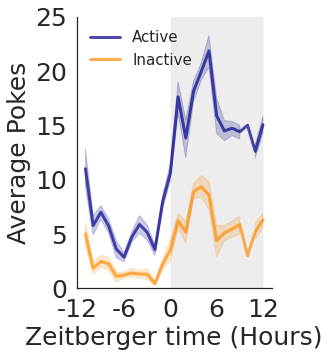

In [15]:
#Fig 4C
import matplotlib.ticker as ticker


###graph:

sns_plot, ax = plt.subplots(figsize = (3.5,5))
sns.set_style("white")

sns_plot = sns.lineplot(data = df_circ, 
                   y = "Successes_binned", x = "phase_shifted", color='darkblue', label='Active', lw=3, ci=67, alpha=.7)


sns_plot = sns.lineplot(data = df_circ, 
                   y = "Errors_binned", x = "phase_shifted", color='darkorange', label='Inactive', lw=3, ci=67, alpha=.7)

plt.fill([12,24,24,12],[0,0,35,35],'black',alpha=0.07)
x = [1,2,3,4,5,6,7]

labels = ['a','-12','-6','0','6','12']
plt.xticks(x, labels, rotation='horizontal')

#plt.title("Baseline", fontsize=20)
plt.ylabel("Average Pokes", fontsize=25)
plt.xlabel("Zeitberger time (Hours)", fontsize = 25)
plt.tick_params(axis='y', which='major', labelsize=25)
plt.tick_params(axis='x', which='major', labelsize=25)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
plt.ylim(0,25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper left',prop={'size': 15}, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

from google.colab import files
plt.savefig("6day_circ.pdf", bbox_inches = 'tight')
files.download("6day_circ.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

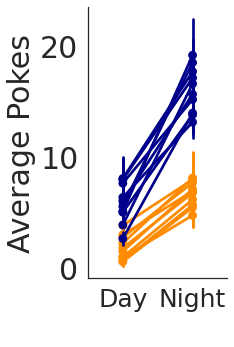

In [18]:
#Fig 4D
my_pal_successs = {'FED10.CSV':"darkblue",'FED9.CSV':"darkblue",'FED7.CSV':"darkblue",'FED5.CSV':"darkblue",'FED2.CSV':"darkblue",'FED4.CSV':"darkblue",'FED8.CSV':"darkblue",'FED6.CSV':"darkblue",'FED1.CSV':"darkblue",'FED3.CSV':"darkblue",}

sns_plot, ax = plt.subplots(figsize = (2.5,5))
sns.set_style("white")
sns_plot = sns.pointplot(data = df_binned_multi,
           y = "Successes_binned", x = "Nighttime", 
           order=[0, 1],  label='Active',
           hue = "filename", palette = my_pal_successs,
           scale=1)


my_pal_errors = {'FED10.CSV':"darkorange",'FED9.CSV':"darkorange",'FED7.CSV':"darkorange",'FED5.CSV':"darkorange",'FED2.CSV':"darkorange",'FED4.CSV':"darkorange",'FED8.CSV':"darkorange",'FED6.CSV':"darkorange",'FED1.CSV':"darkorange",'FED3.CSV':"darkorange",}
sns_plot = sns.pointplot(data = df_binned_multi,
                   y = "Errors_binned", x = "Nighttime",
           order=[0, 1], label='Inactive',  
           hue = "filename", palette = my_pal_errors,
           scale=1)


handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper left',prop={'size': 15}, frameon=False)


x = [0,1]
labels = ["Day","Night"]
plt.xticks(x, labels, rotation='horizontal')

plt.ylabel("Average Pokes", fontsize=30)
plt.xlabel(" ", fontsize = 25)
plt.tick_params(axis='y', which='major', labelsize=30)
plt.tick_params(axis='x', which='major', labelsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend().set_visible(False)
from google.colab import files
plt.savefig("6day_pointp.pdf", bbox_inches = 'tight')
files.download("6day_pointp.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

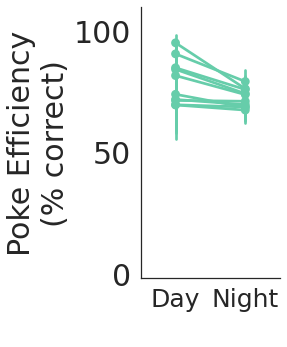

In [20]:
#Fig 4E
my_pal_bias = {'FED10.CSV':"mediumaquamarine",'FED9.CSV':"mediumaquamarine",'FED7.CSV':"mediumaquamarine",'FED5.CSV':"mediumaquamarine",'FED2.CSV':"mediumaquamarine",'FED4.CSV':"mediumaquamarine",'FED8.CSV':"mediumaquamarine",'FED6.CSV':"mediumaquamarine",'FED1.CSV':"mediumaquamarine",'FED3.CSV':"mediumaquamarine",}


sns_plot, ax = plt.subplots(figsize = (2.5,5))
sns.set_style("white")
sns_plot = sns.pointplot(data = df_circ,
           y = "active_bias", x = "Nighttime", palette = my_pal_bias, 
           order=[0, 1],
           hue = "filename",
           scale=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(loc='upper left',prop={'size': 15}, frameon=False)
plt.ylim(-2,110)

x = [0,1]
labels = ["Day","Night"]
plt.xticks(x, labels, rotation='horizontal')

plt.ylabel("Poke Efficiency\n(% correct)", fontsize=30)
plt.xlabel(" ", fontsize = 25)
plt.tick_params(axis='y', which='major', labelsize=30)
plt.tick_params(axis='x', which='major', labelsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend().set_visible(False)

from google.colab import files
plt.savefig("bias_pointp.pdf", bbox_inches = 'tight')
files.download("bias_pointp.pdf")